In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout
plt.rcParams['font.size']=14
img_size = 224

In [ ]:
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1/255.,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            validation_split=0.15)


train_generator = datagen.flow_from_directory('/content/drive/MyDrive/animal10_dataset/raw-img',
                                              target_size=(img_size,img_size),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              subset='training',
                                              #color_mode='grayscale',
                                              class_mode='categorical')


Found 9084 images belonging to 5 classes.


In [ ]:
val_generator = datagen.flow_from_directory('/content/drive/MyDrive/animal10_dataset/raw-img',
                                            target_size=(img_size,img_size),
                                            batch_size=batch_size,
                                            shuffle=False,
                                            subset='validation',
                                            #color_mode='grayscale',
                                            class_mode='categorical')

Found 1600 images belonging to 5 classes.


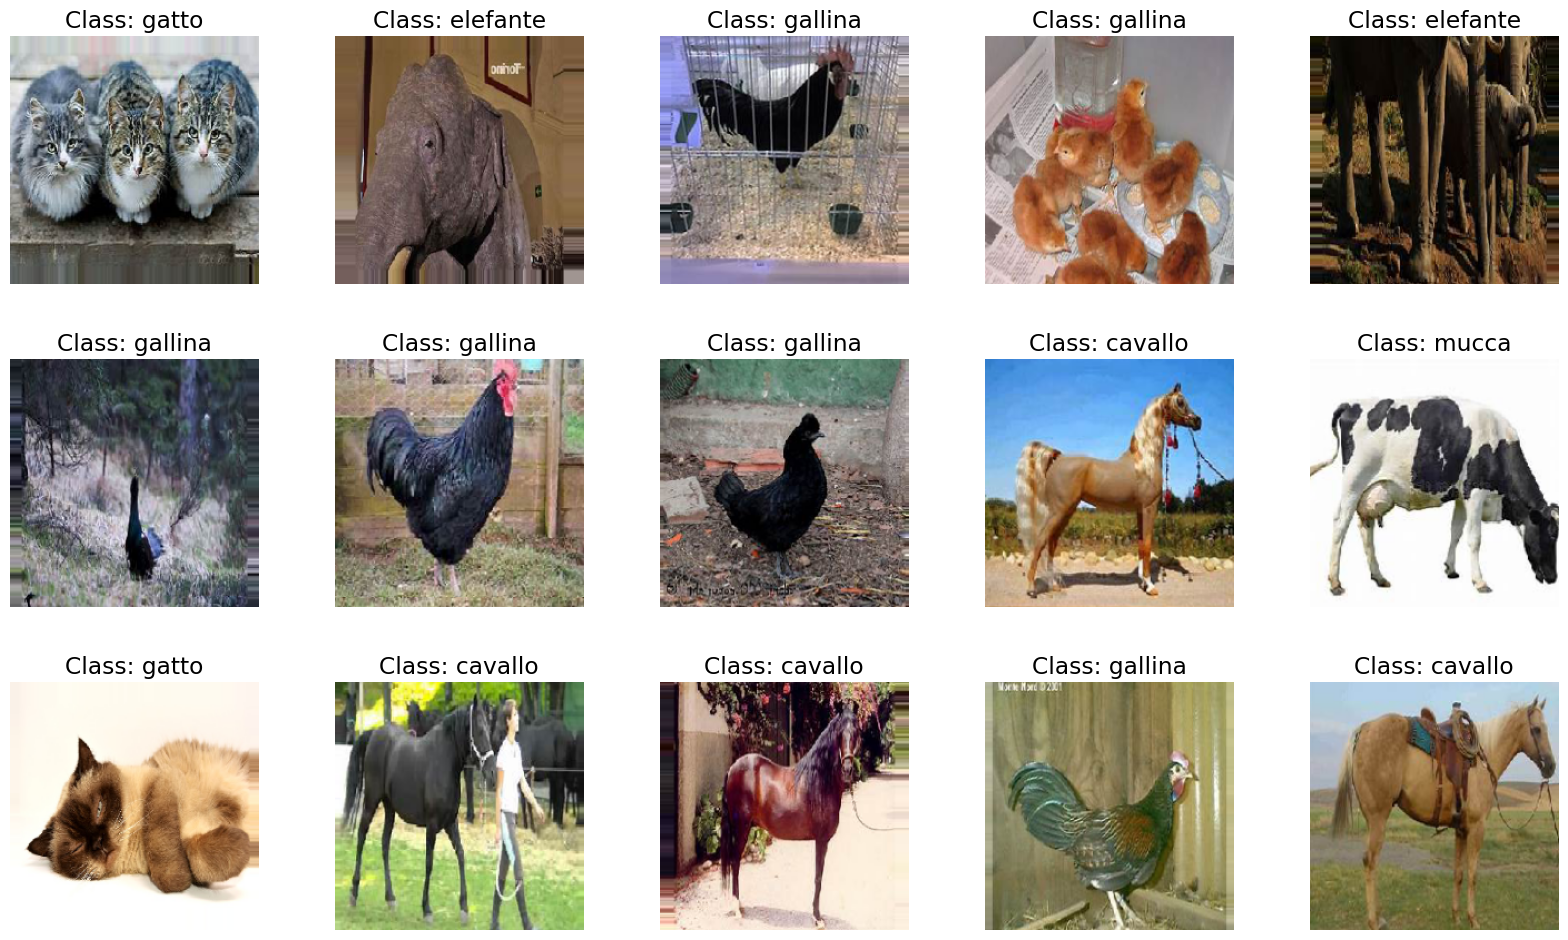

In [ ]:
label = [k for k in train_generator.class_indices]
samples = train_generator.__next__()
images = samples[0]
titles = samples[1]
plt.figure(figsize=(20,20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {label[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")

In [ ]:
base_model=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
len(base_model.layers)

19

In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model_name = "model99.h5"
Checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only = True, verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator,epochs=5,validation_data=val_generator,callbacks=[Checkpoint,es])

Epoch 1/5
284/284 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.7662 

In [ ]:
model = tf.keras.models.load_model("model.h5")

OSError: ignored

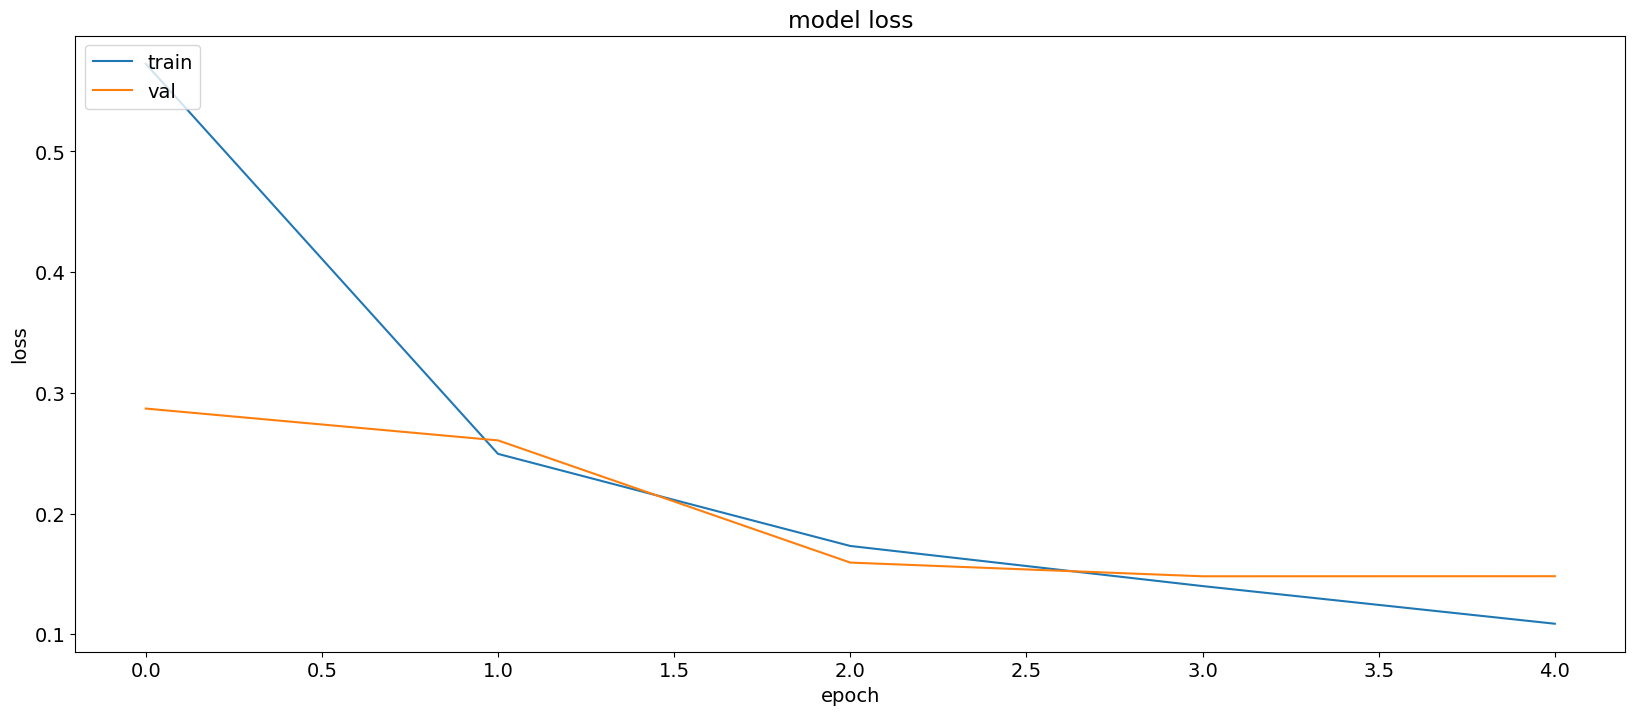

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

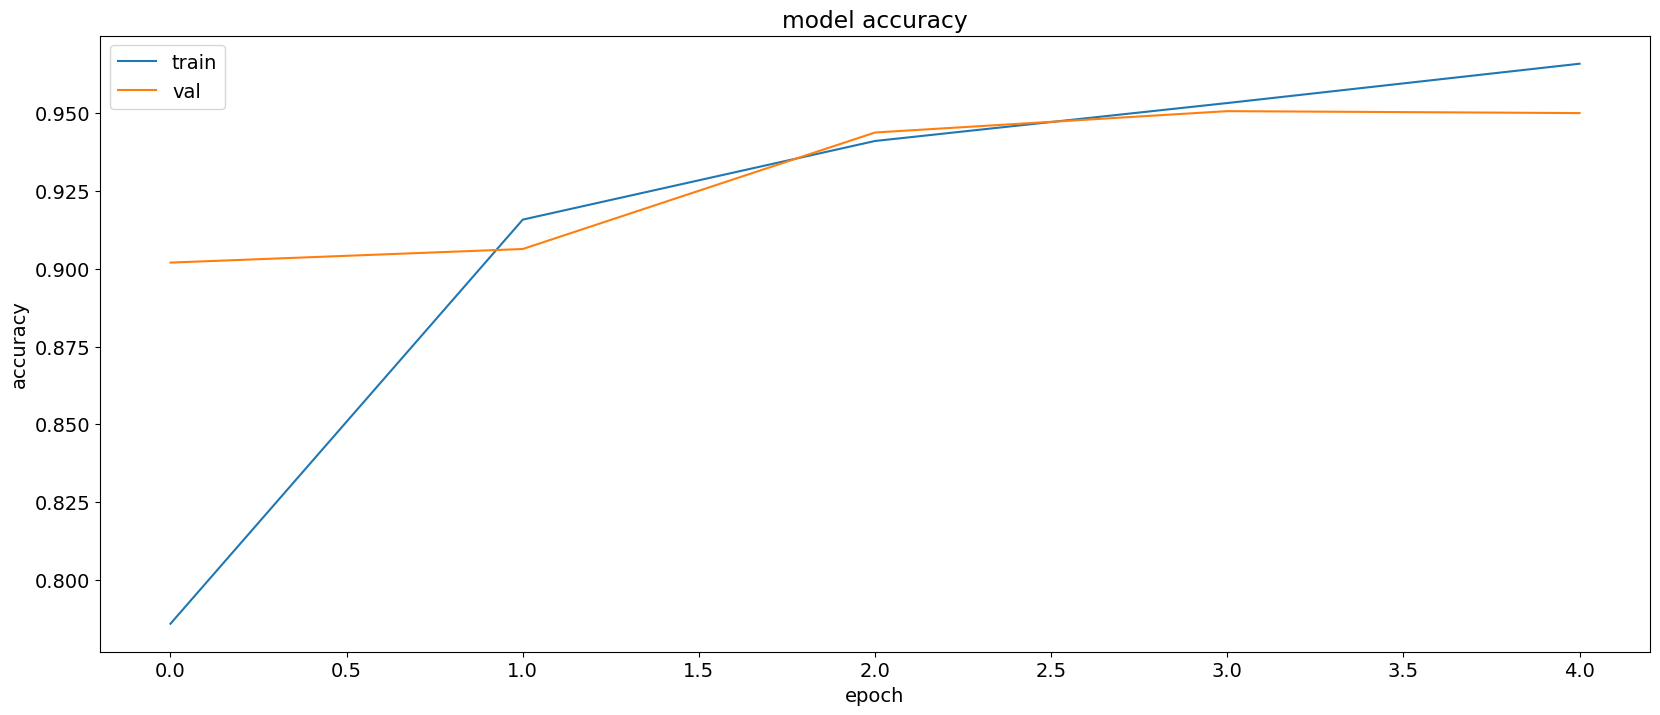

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

51/51 [==============================] - 25s 485ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

              precision    recall  f1-score   support

     cavallo       0.96      0.93      0.94       393
    elefante       0.97      0.94      0.96       216
     gallina       0.99      0.97      0.98       464
       gatto       0.94      0.98      0.96       250
       mucca       0.90      0.97      0.93       279

    accuracy                           0.96      1602
   macro avg       0.95      0.96      0.95      1602
weighted avg       0.96      0.96      0.96      1602



In [ ]:
import numpy as np
from PIL import Image

In [ ]:
img = Image.open('/content/drive/MyDrive/pro/raw-img/gallina/100.jpeg')
img = img.resize((224,224))
img_array = np.array(img)
img_array = np.expand_dims(img_array,axis=0)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
img_array = preprocess_input(img_array)

In [ ]:
pred = model.predict(img_array)

1/1 [==============================] - 1s 928ms/step


In [ ]:
class_idx = np.argmax(pred , axis=1)[0]

In [ ]:
class_names = ['horse','elephant','chicken','cat','cow']

In [ ]:
class_name = class_names[class_idx]

In [ ]:
print('The predicted class is:' , class_name)

The predicted class is: cat


In [ ]:
img = Image.open('/content/drive/MyDrive/pro/raw-img/gallina/100.jpeg')
img = img.resize((224,224))
img_array = np.array(img)
img_array = np.expand_dims(img_array,axis=0)


In [ ]:
pred = model.predict(img_array)
class_idx = np.argmax(pred , axis=1)[0]
class_names = ['horse','elephant','chicken','cat','cow']
class_name = class_names[class_idx]
print('The predicted class is:' , class_name)

1/1 [==============================] - 0s 21ms/step
The predicted class is: horse


In [ ]:
img = Image.open('/content/drive/MyDrive/pro/raw-img/mucca/OIP--FJF1fAEKYhaAYF7cVpHNgHaFj.jpeg')
img = img.resize((224,224))
img_array = np.array(img)
img_array = np.expand_dims(img_array,axis=0)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
img_array = preprocess_input(img_array)
pred = model.predict(img_array)
class_idx = np.argmax(pred , axis=1)[0]
class_names = ['horse','elephant','chicken','cat','cow']
class_name = class_names[class_idx]
print('The predicted class is:' , class_name)

1/1 [==============================] - 0s 25ms/step
The predicted class is: cow


In [ ]:
img = Image.open('/content/drive/MyDrive/pro/raw-img/gatto/420.jpeg')
img = img.resize((224,224))
img_array = np.array(img)
img_array = np.expand_dims(img_array,axis=0)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
img_array = preprocess_input(img_array)
pred = model.predict(img_array)
class_idx = np.argmax(pred , axis=1)[0]
class_names = ['horse','elephant','chicken','cat','cow']
class_name = class_names[class_idx]
print('The predicted class is:' , class_name)

1/1 [==============================] - 0s 22ms/step
The predicted class is: cat


In [ ]:
img = Image.open('//content/drive/MyDrive/pro/raw-img/gallina/1054.jpeg')
img = img.resize((224,224))
img_array = np.array(img)
img_array = np.expand_dims(img_array,axis=0)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
img_array = preprocess_input(img_array)
pred = model.predict(img_array)
class_idx = np.argmax(pred , axis=1)[0]
class_names = ['horse','elephant','chicken','cat','cow']
class_name = class_names[class_idx]
print('The predicted class is:' , class_name)

1/1 [==============================] - 0s 26ms/step
The predicted class is: chicken


In [ ]:
img = Image.open('/content/drive/MyDrive/pro/raw-img/elefante/OIP-0SvmYvIvrQp38UQ99X8xQQHaFA.jpeg')
img = img.resize((224,224))
img_array = np.array(img)
img_array = np.expand_dims(img_array,axis=0)

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
img_array = preprocess_input(img_array)
pred = model.predict(img_array)
class_idx = np.argmax(pred , axis=1)[0]
class_names = ['horse','elephant','chicken','cat','cow']
class_name = class_names[class_idx]
print('The predicted class is:' , class_name)

1/1 [==============================] - 0s 31ms/step
The predicted class is: elephant


In [ ]:
model.save("model.hdf5")

NameError: ignored

In [ ]:
from keras.models import save_model
save_model(model,"model.hdf5")

NameError: ignored